In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.cuda.amp as amp
from torch.nn.parallel import DataParallel
from torch.utils.data.distributed import DistributedSampler
import multiprocessing
import torch.nn.functional as F

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0)
# 归一化函数


def normalize(data, method='minmax', min_value=None, max_value=None):
    """
    多方法归一化函数
    
    参数:
    - data: 需要归一化的数组或数据框列
    - method: 归一化方法，可选['minmax', 'standard', 'log', 'log_minmax']
    - min_value: 最小值（可选）
    - max_value: 最大值（可选）
    
    返回:
    - 归一化后的数据
    - 用于反归一化的参数字典
    """
    params = {}
    
    if method == 'minmax':
        if min_value is None:
            min_value = data.min()
        if max_value is None:
            max_value = data.max()
        normalized_data = (data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    elif method == 'standard':
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        normalized_data = pd.Series(normalized_data, index=data.index)  # 转换回Series
        params = {'mean': scaler.mean_, 'std': scaler.scale_}
        
    elif method == 'log':
        normalized_data = np.log1p(data)
        params = {'method': 'log'}
        
    elif method == 'log_minmax':
        # 先对数变换
        log_data = np.log1p(data)
        # 再归一化
        if min_value is None:
            min_value = log_data.min()
        if max_value is None:
            max_value = log_data.max()
        normalized_data = (log_data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return normalized_data, params

def denormalize(normalized_data, params, method='minmax'):
    """
    多方法反归一化函数
    
    参数:
    - normalized_data: 归一化后的数据
    - params: 归一化参数字典
    - method: 归一化方法，需要与normalize函数使用的方法相同
    
    返回:
    - 反归一化后的原始数据
    """
    if method == 'minmax':
        original_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        
    elif method == 'standard':
        original_data = normalized_data * params['std'] + params['mean']
        
    elif method == 'log':
        original_data = np.expm1(normalized_data)
        
    elif method == 'log_minmax':
        # 先反归一化
        log_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        # 再指数变换
        original_data = np.expm1(log_data)
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return original_data

In [32]:
# 采用对数归一化
Power_normalized,Power_params=normalize(df['Power (MW)'],method='minmax')


In [35]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Input
from sklearn.preprocessing import StandardScaler




# 定义模型类并实现训练及预测方法
class model4():
    def __init__(self,train_data,test_data,train_windows,cnn_units=5):
        self.input_window_size = len(train_data[1])
        self.cnn_units = cnn_units
        self.test_data = test_data
        self.train_data = train_data
        self.model = None
        self.real_values = train_windows
        self.input_shape=(self.input_window_size-1, 1)  
    def build_model(self):
        inputs = Input(shape=self.input_shape)

                                                    # 第一个卷积层
        x = Conv1D(filters=128, kernel_size=29, activation='relu', padding='same')(inputs)
        x = MaxPooling1D(pool_size=3)(x)
                                                    # 添加第二个卷积层
        x = Conv1D(filters=64, kernel_size=16, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2)(x)
                                                    # 添加第三个卷积层
        x = Conv1D(filters=32, kernel_size=8, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2)(x)
                                                    # 转换为一维向量
        x = Flatten()(x)
                                                    # 添加全连接层
        x = Dense(units=128, activation='relu')(x)
                                                    # 输出层
        outputs = Dense(units=1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.model=model
        

    def preprocess_data(self, data):
        X = np.array([np.array(window[:-1]).reshape(1, -1, 1) for window in data])
        X = X.reshape((X.shape[0], X.shape[2], 1))
        y = np.array([window[-1] for window in data])
        return X, y   
    def fit_models(self, X_train, y_train, epochs=20, batch_size=30, verbose=1):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    def predict(self, X_test):
        if not self.model:
            raise ValueError("Model needs to be built and trained before making predictions.")
        y_test_pred = self.model.predict(X_test)
        return y_test_pred 
    
    def train_and_test(self):
        X_train, y_train = self.preprocess_data(self.train_data)
        X_test, y_test = self.preprocess_data(self.test_data)
        self.build_model()
        self.fit_models(X_train, y_train)
        y_test_pred = self.predict(X_test)
        return y_test_pred,y_test   
    # def iterate_prediction(self, n_days_data, target,times=50):
    #     l1 = np.array(n_days_data[-self.input_window_size+1:])
    #     l1 = l1.reshape(1, -1, 1)  # 确保l1的初始形状与模型输入一致
    #     pred_results = []  # 初始化预测结果列表
    #     real_results = []  # 初始化真实结果列表

    #     x = len(target) - len(n_days_data)

    #     for i in range(times):
    #         if x + i+1 < len(target):
    #             next_value_true = target[x + 1 + i][-1]
    #             real_results.append(next_value_true)

    #             # 进行预测并收集预测结果
    #             prediction = self.predict(l1)[0, -1]
    #             pred_results.append(prediction)

    #             # 更新l1，只保留预测结果的前input_window_size-1个值，并加上最新的预测值
    #             l1 = np.concatenate((l1[:, 1:], np.array([[prediction]])[:, None]), axis=1)
    #         else:
    #             break

        # 返回经过迭代预测后的序列和真实的后续观测值
        # return np.array(pred_results), np.array(real_results)[:times]
    def iterate_prediction(self, n_days_data,times=50):
        l1 = np.array(n_days_data[-self.input_window_size+1:])
        l1 = l1.reshape(1, -1, 1)  # 确保l1的初始形状与模型输入一致
        pred_results = []  # 初始化预测结果列表

        for i in range(times):

            # 进行预测并收集预测结果
            prediction = self.predict(l1)[0, -1]
            pred_results.append(prediction)

            # 更新l1，只保留预测结果的前input_window_size-1个值，并加上最新的预测值
            l1 = np.concatenate((l1[:, 1:], np.array([[prediction]])[:, None]), axis=1)

        # 返回经过迭代预测后的序列和真实的后续观测值
        return np.array(pred_results)

In [36]:


def train_data_method(data, window, step=1):
    train_data = []
    for i in range(0, len(data) - window, step):
        train_data.append(data[i:i + window])
    return train_data

window_size = 24
days_to_predict = 24

data = train_data_method(Power_normalized.values.tolist(), window_size)[:-days_to_predict]
target_data = train_data_method(Power_normalized.values.tolist(), window_size)[-days_to_predict:]

In [37]:
train_data=data[:round(len(data)*0.8)]
test_data=data[round(len(data)*0.8):]

In [38]:
p650 = model4(train_data, test_data,train_windows=window_size)
p650.train_and_test()

Epoch 1/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0065
Epoch 2/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0030
Epoch 3/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0028
Epoch 4/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0028
Epoch 5/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0028
Epoch 6/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 7/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 8/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 9/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 10/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 11/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0026
Epoch 12/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 13/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027
Epoch 14/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0026
Epoch 15/20
1813/1813 ━━━━━━

(array([[0.00368921],
        [0.00368921],
        [0.00368921],
        ...,
        [0.01741364],
        [0.00956036],
        [0.00388311]], dtype=float32),
 array([0.00185018, 0.00227418, 0.01576509, ..., 0.00629833, 0.00166516,
        0.00372349]))

In [39]:
# 获取iterate_prediction方法生成的预测值和真实值列表
predicted_values = p650.iterate_prediction(test_data[len(test_data)-1],window_size)


# 将真实值列表转换为numpy数组
# real_values_array = np.array(real_values_list)

# 调用plot_predicted_values函数
print(predicted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.00475868 0.00668347 0.00799497 0.0069328  0.00667306 0.00709479
 0.00715398 0.0076097

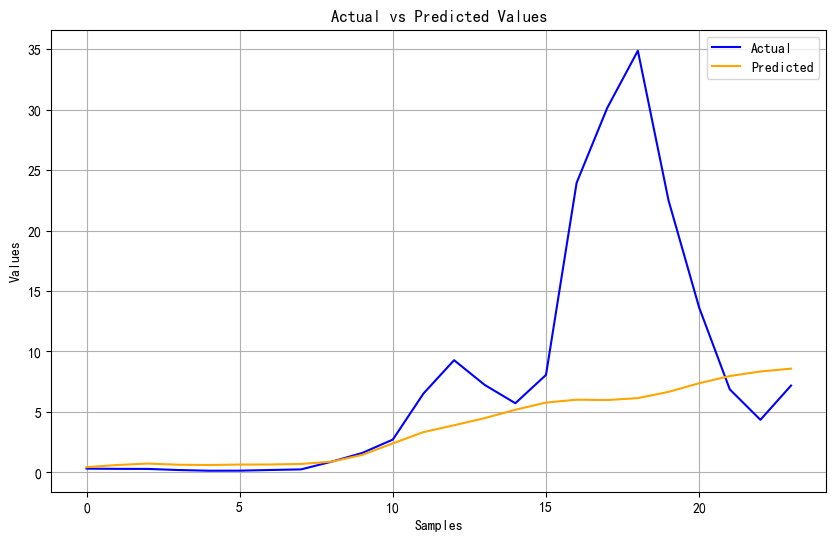

In [40]:
predicted_values=denormalize(predicted_values,Power_params,method='minmax')
actual_values=denormalize(np.array(target_data[-1]),Power_params,method='minmax')    
# 绘制实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(predicted_values, label='Predicted', color='orange')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 计算评估指标
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# 输出结果
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 4.88290602618734
MSE: 87.16115544052462
RMSE: 9.336013894619299
R²: 0.10356210193802773


In [43]:
predicted_values.tolist()

[0.4386196434497833,
 0.6160325407981873,
 0.7369168400764465,
 0.6390141248703003,
 0.6150728464126587,
 0.6539455056190491,
 0.6594011783599854,
 0.7014074325561523,
 0.8941442370414734,
 1.4503381252288818,
 2.407179594039917,
 3.3349406719207764,
 3.90328311920166,
 4.492984771728516,
 5.180691242218018,
 5.778274059295654,
 6.015015602111816,
 5.987796783447266,
 6.144660949707031,
 6.661772727966309,
 7.375347137451172,
 7.971968173980713,
 8.346333503723145,
 8.582728385925293]

In [47]:
X_test, y_test = p650.preprocess_data(test_data[:100])
y_test_pred = p650.predict(X_test)
# 反归一化预测值和真实值
y_test_pred_denorm = denormalize(y_test_pred.flatten(), Power_params, method='log_minmax')
y_test_denorm = denormalize(y_test, Power_params, method='log_minmax')

# 计算评估指标
mae = mean_absolute_error(y_test_denorm, y_test_pred_denorm)
mse = mean_squared_error(y_test_denorm, y_test_pred_denorm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denorm, y_test_pred_denorm)

# 输出结果
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 1.232498320319141e+27
MSE: 3.4929090923553357e+55
RMSE: 5.910083833885383e+27
R²: -0.10120311411600302
